# Instructions

Ce notebook ne doit contenir que votre script servant à l'entrainement de votre modèle. Nous devons pouvoir l'exécuter en cliquant sur *Exécution -> Tout exécuter*.

Veuillez également ajouter des commentaires dans votre code pour expliquer ce que vous faites. N'hésitez pas à ajouter des blocs de textes (cliquez sur le bouton *+ Texte* en dessous du menu) pour ajouter plus d'explications.

Vous devrez déposer sur Moodle une archive au format .zip contenant un dossier avec vos noms.

Dans ce dossier, nous devons retrouver les deux notebooks (training et testing) ainsi qu'un nouveau dossier *models* contenant les poids de vos modèles entrainés, et si nécessaire un dossier *datasets* contenant d'autres données utilisée pour effectuer l'apprentissage de vos modèles (données obtenues par récupération sur le web "web scraping"  ou bien augmentation de données "data augmentation"). Si vous effectuez de l'augmentation de données, fournissez aussi le code pour la réaliser dans le notebook.

# Installation et importation des librairies

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk

import os
import numpy as np

from datasets import load_dataset

import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer

import shutil


# Paramétrage de numpy et désactivation de wandb

In [3]:
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=False, threshold=1000, formatter=None)
os.environ["WANDB_DISABLED"] = "true"

# Fichier d'entraînement et de test

Pour le fichier d'entraînement il y a celui de base fourni qui est "fake_train.csv" et celui que j'ai fait moi même pour augmenter les données dont la méthode de data augmentation est détaillée dans le rapport.

In [6]:
train_file_path = 'translated_news_cleaned_with_train_10000.csv'
train_file_path = 'translated_news_cleaned_with_train_3000.csv'
#train_file_path = 'fake_train.csv'
test_file_path = 'fake_test.csv'

dataset_train = load_dataset("csv", data_files=train_file_path, split='train')
dataset_test = load_dataset("csv", data_files=test_file_path, split='train')

print("Nombre de news dans le dataset d'entraînement:", len(dataset_train))
print("Nombre de news dans le dataset de test:", len(dataset_test))

Generating train split: 0 examples [00:00, ? examples/s]

Nombre de news dans le dataset d'entraînement: 10334
Nombre de news dans le dataset de test: 486


# Fonction pour afficher l'accuracy d'un modèle avec ses prédictions

In [7]:
def view_result(predictions):
  print("Résultats de l'évaluation :")
  print(predictions.metrics)

  preds = predictions.predictions.argmax(-1)  # Labels prédits
  labels = predictions.label_ids  # Labels réels

  accuracy = accuracy_score(labels, preds)
  print(f"Précision : {accuracy:.2%}")

# Fonction pour afficher la confusion matrix

In [8]:
def plot_confusion_matrix(predictions):
  preds = predictions.predictions.argmax(-1)
  labels = predictions.label_ids
  cm = confusion_matrix(labels, preds)

  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Prédictions")
  plt.ylabel("Vérités")
  plt.title("Matrice de Confusion")
  plt.show()


# Fonction de prétraitement pour transformer le texte en token que le modèle peut traiter

In [9]:
from transformers import AutoTokenizer

def preprocess_function(examples):
    return tokenizer(examples['data'], truncation=True, padding=True)

# Fonction de calcul des métriques d'accuracy pour le Trainer

In [10]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Fonction pour entraîner et évaluer un modèle


In [11]:
def train_and_evaluate(model_id, num_labels=2, epochs=3, batch_size=16, learning_rate=2e-5):
    # Chargement du tokenizer et du modèle
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels).cuda()

    # Application du prétraitement
    tokenized_train = dataset_train.map(preprocess_function, batched=True)
    tokenized_test = dataset_test.map(preprocess_function, batched=True)

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Arguments d'entraînement
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        metric_for_best_model="accuracy",
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True
    )

    # Entraîneur
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Entraînement
    trainer.train()

    # Sauvegarde du modèle
    trainer.save_model(model_id)

    # Évaluation sur le dataset de test
    eval_results = trainer.evaluate()
    print("Evaluation results: ", eval_results)

    return eval_results, model_id, trainer, tokenized_test


# Fonction pour sauvegarder un modèle entrainer

Une fois le modèle entrainer il faut télécharger le .zip qui va servir pour le fichier DéfisIA-NLP-2024-Remise-Testing-Script_sklearn.ipynb et ainsi avoir l'accuracy du modèle

In [12]:
def save_model(model_path, trainer):
  trainer.save_model(model_path)
  shutil.make_archive(model_path, 'zip', model_path)

# Entrainement 1 : camembert-base

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-15-77a9621fa9ff>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.211694,0.938272
2,0.159900,0.191132,0.952675
3,0.159900,0.182126,0.960905


Evaluation results:  {'eval_loss': 0.18212644755840302, 'eval_accuracy': 0.9609053497942387, 'eval_runtime': 15.1779, 'eval_samples_per_second': 32.02, 'eval_steps_per_second': 2.042, 'epoch': 3.0}
Résultats de l'évaluation :
{'test_loss': 0.18212644755840302, 'test_accuracy': 0.9609053497942387, 'test_runtime': 15.6198, 'test_samples_per_second': 31.114, 'test_steps_per_second': 1.985}
Précision : 96.09%


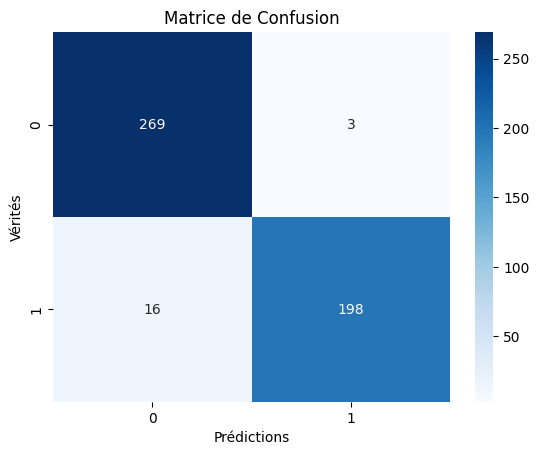

In [ ]:
model_id = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Entraînement et évaluation du modèle
eval_results, model_path, trainer, tokenized_test = train_and_evaluate(model_id)
# Évaluation complète avec Trainer
predictions = trainer.predict(tokenized_test)
view_result(predictions)
plot_confusion_matrix(predictions)
save_model(model_id, trainer)

# Entraînement 2 : dbmdz/bert-base-french-europeana-cased

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-french-europeana-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10334 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-8b70cb5c60f1>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.131200,0.150630,0.958848
2,0.028100,0.180375,0.969136
3,0.011000,0.173617,0.971193


Evaluation results:  {'eval_loss': 0.17361725866794586, 'eval_accuracy': 0.9711934156378601, 'eval_runtime': 14.1798, 'eval_samples_per_second': 34.274, 'eval_steps_per_second': 2.186, 'epoch': 3.0}
Résultats de l'évaluation :
{'test_loss': 0.17361725866794586, 'test_accuracy': 0.9711934156378601, 'test_runtime': 14.6134, 'test_samples_per_second': 33.257, 'test_steps_per_second': 2.121}
Précision : 97.12%


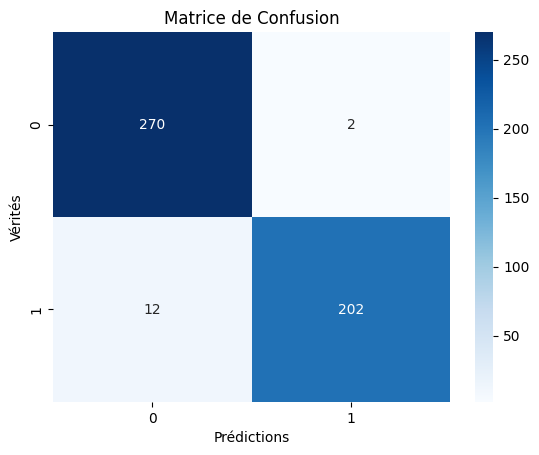

In [13]:
model_id = "dbmdz/bert-base-french-europeana-cased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Entraînement et évaluation du modèle
eval_results, model_path, trainer, tokenized_test = train_and_evaluate(model_id)
# Évaluation complète avec Trainer
predictions = trainer.predict(tokenized_test)
view_result(predictions)
plot_confusion_matrix(predictions)
save_model(model_id, trainer)


# Entraînement 3 : hamzab/roberta-fake-news-classification

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/4071 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-8b70cb5c60f1>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.354366,0.915638
2,0.279500,0.569158,0.882716
3,0.279500,0.319633,0.934156


Evaluation results:  {'eval_loss': 0.31963348388671875, 'eval_accuracy': 0.934156378600823, 'eval_runtime': 14.8209, 'eval_samples_per_second': 32.791, 'eval_steps_per_second': 2.092, 'epoch': 3.0}
Résultats de l'évaluation :
{'test_loss': 0.31963348388671875, 'test_accuracy': 0.934156378600823, 'test_runtime': 15.1687, 'test_samples_per_second': 32.04, 'test_steps_per_second': 2.044}
Précision : 93.42%


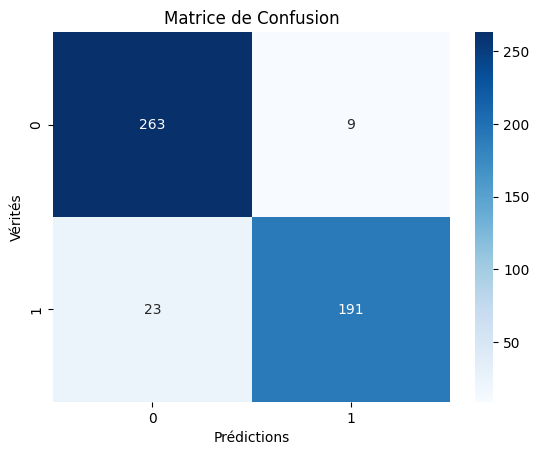

In [ ]:
model_id = "hamzab/roberta-fake-news-classification"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Entraînement et évaluation du modèle
eval_results, model_path, trainer, tokenized_test = train_and_evaluate(model_id)
# Évaluation complète avec Trainer
predictions = trainer.predict(tokenized_test)
view_result(predictions)
plot_confusion_matrix(predictions)
save_model(model_id, trainer)

# Entraînement 4 : xlm-roberta-base

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4071 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-8b70cb5c60f1>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.224196,0.944444
2,0.211800,0.277631,0.950617
3,0.211800,0.255367,0.954733


Evaluation results:  {'eval_loss': 0.2553673982620239, 'eval_accuracy': 0.9547325102880658, 'eval_runtime': 14.9195, 'eval_samples_per_second': 32.575, 'eval_steps_per_second': 2.078, 'epoch': 3.0}
Résultats de l'évaluation :
{'test_loss': 0.2553673982620239, 'test_accuracy': 0.9547325102880658, 'test_runtime': 15.0411, 'test_samples_per_second': 32.311, 'test_steps_per_second': 2.061}
Précision : 95.47%


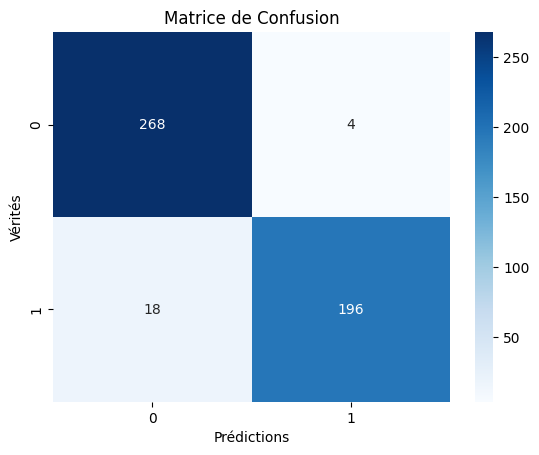

In [ ]:
model_id = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Entraînement et évaluation du modèle
eval_results, model_path, trainer, tokenized_test = train_and_evaluate(model_id)
# Évaluation complète avec Trainer
predictions = trainer.predict(tokenized_test)
view_result(predictions)
plot_confusion_matrix(predictions)
save_model(model_id, trainer)